In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

import pandas as pd
import numpy as np

from index_option_analysis import solve_marks, spot_compute_iv, spot_greeks_from

In [2]:
S0 = 900 # a very crude guess at the spot index price

In [3]:
basic_folio = pd.DataFrame.from_records(
    [(141, 'PUT', 500,  20),
     (141, 'PUT', 1000, -20 ),
     (141, 'CALL', 500, -20 ),
     (141, 'CALL', 1000,  20 ),
    ],
    columns=['dte','putCall','strikePrice','quantity'],
)

basic_folio

,dte,putCall,strikePrice,quantity
0,141,PUT,500,20
1,141,PUT,1000,-20
2,141,CALL,500,-20
3,141,CALL,1000,20


In [4]:
# load option prices as of the snapshot time
option_data = pd.read_csv('../data/generic_at_330pm.csv')
option_data

,strikePrice,dte,putCall,bid,ask
0,40.0,22,CALL,877.80,879.24
1,80.0,22,CALL,837.82,839.24
2,120.0,22,CALL,797.82,799.24
3,160.0,22,CALL,757.84,759.26
4,200.0,22,CALL,717.86,719.26
...,...,...,...,...,...
4571,1380.0,778,PUT,457.82,462.62
4572,1400.0,778,PUT,477.06,481.86
4573,1420.0,778,PUT,496.34,501.14
4574,1440.0,778,PUT,515.66,520.46


In [5]:
dtes = sorted(option_data.dte.unique())

print('Available dtes: ')
print(dtes)

Available dtes: 
[22, 50, 85, 113, 141, 168, 204, 232, 260, 295, 323, 358, 386, 414, 449, 596, 778]


In [6]:
# add some useful fields to the option data
chains = option_data.copy()
chains['is_call'] = (chains.putCall == 'CALL')
chains['tau'] = chains['dte'] / 365.
chains['mid'] = 0.5 * (chains['bid'] + chains['ask'])
chains['spread'] = (chains['ask'] - chains['bid'])

In [7]:
df = chains.copy()

marks_by_dte = {}
for dte in dtes:
    chain = df[df.dte==dte].pivot('strikePrice','putCall').sort_index().dropna(how='any')
    marks_by_dte[dte] = solve_marks(chain, S0=S0, dte=dte, obj_weight=0.)

rates = pd.DataFrame.from_records([
    (dte, dte/365., data['r'], data['F'])
    for dte,data in marks_by_dte.items()
], columns=['dte','tau','int_rate', 'fwd']).set_index('dte')
rates['spot'] = rates.fwd.iloc[0] # use front month fwd as proxy for spot
rates['div_yld'] = [np.log(rates.loc[dte].spot/data['F'])/(rates.loc[dte].tau) + data['r'] 
                        for dte,data in marks_by_dte.items()]

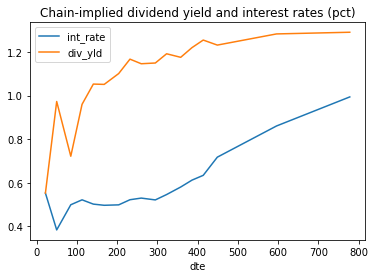

In [8]:
(100*rates[['int_rate','div_yld']]).plot(title='Chain-implied dividend yield and interest rates (pct)');

In [9]:
marks_list = []
for dte,data in marks_by_dte.items():
    marks = data['marks'][['mark_call','mark_put']].copy()
    marks.columns = ['CALL','PUT']
    marks.columns.name = 'putCall'
    marks = marks.stack().to_frame('mark')
    marks['dte'] = dte
    marks_list.append(marks.reset_index())
clean_marks = pd.merge(
    pd.concat(marks_list, axis=0, ignore_index=True),
    rates[['tau', 'int_rate', 'div_yld', 'spot']],
    on='dte')
clean_marks['is_call'] = (clean_marks.putCall=='CALL')

clean_marks['imp_vol'] = spot_compute_iv(
    tgt=clean_marks.mark,
    spot=clean_marks.spot,
    strike=clean_marks.strikePrice,
    tau=clean_marks.tau,
    is_call=clean_marks.is_call,
    int_rate=clean_marks.int_rate,
    div_yld=clean_marks.div_yld,
)

chains_with_rates = clean_marks

In [10]:
folio_cols = ['price','delta','theta','gamma','vega','wt_vega']

folio = pd.merge(chains_with_rates, basic_folio, on=['dte','putCall','strikePrice'])

# compute implied vol for each option
folio['imp_vol'] = spot_compute_iv(
    tgt=folio.mark,
    spot=folio.spot,
    strike=folio.strikePrice,
    tau=folio.tau,
    is_call=folio.is_call,
    int_rate=folio.int_rate,
    div_yld=folio.div_yld,
)

# compute greeks for each option
greeks = spot_greeks_from(
    spot=folio.spot,
    strike=folio.strikePrice,
    tau=folio.tau,
    sigma=folio.imp_vol,
    is_call=folio.is_call,
    int_rate=folio.int_rate,
    div_yld=folio.div_yld,
)

for c in folio_cols:
    folio[c] = greeks[c]

# adjust for the 100 multiplier
# note that vega needs no adjustment
folio['value'] = 100*folio['price'] # value per contract
folio['theta'] *= 100/365.          # per contract
folio['delta'] *= 100               # per contract

In [15]:
# Compute portfolio value and greeks
folio_greeks = folio[folio_cols+['value']].mul(folio.quantity, axis=0).sum()
print('Portfolio greeks:\n')
print(folio_greeks.round(2))

print("""
Basic Version had these values:

price       -9996.76
delta         305.89
theta          33.94
gamma           0.06
vega         1812.42
wt_vega       841.79
value     -999676.50

""") 

Portfolio greeks:

price       -9980.61
delta          -0.00
theta           0.00
gamma          -0.00
vega           -0.00
wt_vega        -0.00
value     -998060.61
dtype: float64

Basic Version had these values:

price       -9996.76
delta         305.89
theta          33.94
gamma           0.06
vega         1812.42
wt_vega       841.79
value     -999676.50




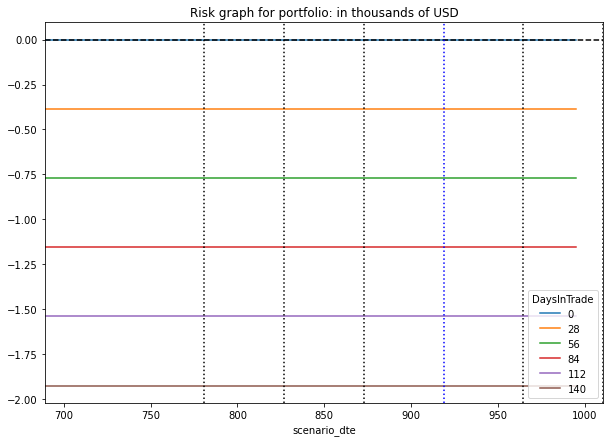

In [12]:
future_dtes = [0, 28, 56, 84, 112, 140]
spots = list(range(600,1000,5))
risk_graph = []
for fut_dte in future_dtes:
    for spot in spots:
        greeks = spot_greeks_from(
            spot=spot,
            strike=folio.strikePrice,
            tau=folio.tau - fut_dte/365.,
            is_call=folio.is_call,
            sigma=folio.imp_vol,
            int_rate=folio.int_rate, # note: int_rate and div_yld are also "sticky"
            div_yld=folio.div_yld,   # and do not roll down the term structure.
        ) 
        risk_graph.append((fut_dte, spot, 100*(greeks['price']*folio['quantity']).sum()))

rg = pd.DataFrame.from_records(risk_graph, columns=['dte','spot','value'])
rg['PnL'] = rg.value - folio_greeks.value

spot = folio.spot.iloc[0]
rgs = rg.pivot('spot','dte','PnL')
rgs.index.name = 'scenario_dte'
rgs.columns.name = 'scenario_spot'
rgs.columns.name = 'DaysInTrade'
(rgs/1000).plot(figsize=(10,7), xlim=[spot * 0.75, spot*1.1], 
         title='Risk graph for portfolio: in thousands of USD');
plt.axhline(y=0., color='k', linestyle='--')
for pct in [0.85, 0.9, 0.95, 1., 1.05, 1.1]:
    color = 'b' if pct==1 else 'k'
    plt.axvline(x=spot*pct, color=color, linestyle=':')